## Last version

In [2]:
import os
os.getcwd()

'c:\\Users\\katyt\\Google Drive\\PhD\\Simulations_semi_super'

In [1]:
import configparser

# Create data configuration object
data_config = configparser.ConfigParser()

# Set default values for data configuration
data_config['data_settings'] = {}
data_config['data_settings']['type_image'] = '-1'
data_config['data_settings']['size'] = '128'
data_config['data_settings']['p'] = '60'
data_config['data_settings']['index'] = '-1'

# Write data configuration to file
with open('data_config_all.ini', 'w') as configfile:
    data_config.write(configfile)

# Create model configuration object
model_config = configparser.ConfigParser()

# Set default values for model configuration
model_config['model_settings'] = {}
model_config['model_settings']['z_dim'] = '1'
model_config['model_settings']['h_dim'] = '14'
model_config['model_settings']['neurons_svrnn'] = '14'
model_config['model_settings']['neurons_vsl'] = '30'
model_config['model_settings']['neurons_tmm'] = '25'
model_config['model_settings']['learning_rate_svrnn'] = '0.007'
model_config['model_settings']['learning_rate_vsl'] = '0.007'
model_config['model_settings']['learning_rate_tmm'] = '0.01'
model_config['model_settings']['n_epochs'] = '100'
model_config['model_settings']['epoch_init'] = '1'
model_config['model_settings']['print_every'] = '5'
model_config['model_settings']['save_every'] = '10'
model_config['model_settings']['add_loss'] = 'True'
model_config['model_settings']['setting'] = '-1'
# Write model configuration to file
with open('model_config_all.ini', 'w') as configfile:
    model_config.write(configfile)

In [7]:
# Simulations gpu
seed = 123
import os
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import random
import torch
import configparser

random.seed(seed)     # python random generator
np.random.seed(seed)  # numpy random generator

torch.manual_seed(seed) # pytorch random generator
torch.cuda.manual_seed_all(seed) # for multi-gpu

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#--------------------------------------------
from models.models_v3 import *
from utils.utils_semi import *
from utils.training import run_model_seq, num_param, run_save_model
#--------------------------------------------
path = os.getcwd()
folder_data = r'Data'
#-------------------------------
if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"  
print('Your actual device',device)
#----------------------------------------------
# Load configuration files
data_config = configparser.ConfigParser()
data_config.read('data_config_all.ini')

model_config = configparser.ConfigParser()
model_config.read('model_config_all.ini')

# Get input values from configuration files or prompt user for input
type_image = data_config.get('data_settings', 'type_image', fallback=None)
if type_image=='-1':
    type_image = input("Enter the type of image (camel or cattle): ")
    data_config.set('data_settings', 'type_image', type_image)
size = data_config.getint('data_settings', 'size', fallback=None)
if size not in [128, 256]:
    size = int(input("Enter the size of the image (128 or 256): "))
    data_config.set('data_settings', 'size', str(size))
p = data_config.getint('data_settings', 'p')
if p<0 or p>100:
    p = int(input("Enter the percentage of missing labels (0 to 100): "))
    data_config.set('data_settings', 'p', str(p))
print(f"Data info: {type_image}, {size}, {p}")
#----------------------------------------------
# Path to save the model
path_data = os.path.join(path, folder_data, type_image+'_'+str(size))
print('Exist this folder', os.path.exists(path_data))
general_path  = os.path.join(os.getcwd(), 'Results_save_models') 
os.makedirs(general_path, exist_ok=True)
print('Saving our model in',general_path)
#----------------------------------------------
list_images = []
names_images = []
for data in sorted(os.listdir(path_data)):
    if data.endswith('.npy') and str(p) in data:
        list_images.append(np.load(os.path.join(path_data, data)))
        names_images.append(data[:-4])

index = data_config.getint('data_settings', 'index')
if index<0:
    index = int(input(f"Enter an index from 0 to {len(list_images)-1}: "))
    if index < 0 or index >= len(list_images):
        raise ValueError
    data_config.set('data_settings', 'index', str(index))

name_image = names_images[index]
print('index', index, name_image)
image_x, y_true, image_y = list_images[index]

x = torch.tensor(image_x.reshape(size*size, 1), dtype=torch.float32)
y = torch.tensor(image_y.reshape(size*size, 1), dtype=torch.float32)

x = x.to(device)
y = y.to(device)
# print(np.max(image_x), np.min(image_x), np.max(image_y), np.min(image_y))
#----------------------------------------------
#! General model settings
x_dim = 1
y_dim = 1
weight_decay_ = 1e-4
clip = 10
# add_loss =True # input("Enter 'True' if add_loss should be True, or 'False' otherwise: ").lower() == 'true'

z_dim = model_config.getint('model_settings', 'z_dim')
if z_dim <0:
    z_dim = int(input("Enter the value for z_dim: "))
    model_config.set('model_settings', 'z_dim', str(z_dim))

h_dim = model_config.getint('model_settings', 'h_dim')
if h_dim <0:
    h_dim = int(input("Enter the value for h_dim: "))
    model_config.set('model_settings', 'h_dim', str(h_dim))

neurons_svrnn = model_config.getint('model_settings', 'neurons_svrnn')
if neurons_svrnn <0:
    neurons_svrnn = int(input("Enter the value for neurons_svrnn: "))
    model_config.set('model_settings', 'neurons_svrnn', str(neurons_svrnn))

neurons_vsl = model_config.getint('model_settings', 'neurons_vsl')

if neurons_vsl <0:
    neurons_vsl = int(input("Enter the value for neurons_vsl: "))
    model_config.set('model_settings', 'neurons_vsl', str(neurons_vsl))

neurons_tmm = model_config.getint('model_settings', 'neurons_tmm')
if neurons_tmm <0:  
    neurons_tmm = int(input("Enter the value for neurons_tmm: "))
    model_config.set('model_settings', 'neurons_tmm', str(neurons_tmm))

learning_rate_svrnn = model_config.getfloat('model_settings', 'learning_rate_svrnn')
if learning_rate_svrnn <0:
    learning_rate_svrnn = float(input("Enter the learning rate for svrnn: "))
    model_config.set('model_settings', 'learning_rate_svrnn', str(learning_rate_svrnn))

learning_rate_vsl = model_config.getfloat('model_settings', 'learning_rate_vsl')
if learning_rate_vsl <0:
    learning_rate_vsl = float(input("Enter the learning rate for vsl: "))
    model_config.set('model_settings', 'learning_rate_vsl', str(learning_rate_vsl)) 

learning_rate_tmm = model_config.getfloat('model_settings', 'learning_rate_tmm')
if learning_rate_tmm <0:
    learning_rate_tmm = float(input("Enter the learning rate for tmm: "))
    model_config.set('model_settings', 'learning_rate_tmm', str(learning_rate_tmm))

n_epochs = model_config.getint('model_settings', 'n_epochs')
if n_epochs <0:
    n_epochs = int(input("Enter the number of epochs: "))
    model_config.set('model_settings', 'n_epochs', str(n_epochs))

epoch_init = model_config.getint('model_settings', 'epoch_init')
if epoch_init <0:
    epoch_init = int(input("Enter the value for epoch_init: "))
    model_config.set('model_settings', 'epoch_init', str(epoch_init))

print_every = model_config.getint('model_settings', 'print_every')
if print_every <0:
    print_every = int(input("Enter the print interval: "))
    model_config.set('model_settings', 'print_every', str(print_every))

save_every = model_config.getint('model_settings', 'save_every')
if save_every <0:
    save_every = int(input("Enter the save interval: "))
    model_config.set('model_settings', 'save_every', str(save_every))

add_loss = model_config.get('model_settings', 'add_loss')
if add_loss:
     add_loss = input("Enter if additional loss function (True False): ")
     model_config.set('model_settings', 'add_loss', add_loss)

setting = model_config.get('model_settings', 'setting')
if setting == '-1':
    setting = '' if add_loss else 'no_add'
    model_config.set('model_settings', 'setting', setting)

#--------------------------------------------
print('Data settings:')
print(f'index: {index}, name_image: {name_image}, size: {size}')
print(f'x_dim: {x_dim}, y_dim: {y_dim}, weight_decay: {weight_decay_}, clip: {clip}')
print('Model settings:')
print(f'z_dim: {z_dim}, h_dim: {h_dim}, neurons_svrnn: {neurons_svrnn}, neurons_vsl: {neurons_vsl}, neurons_tmm: {neurons_tmm}')
print(f'learning_rate_svrnn: {learning_rate_svrnn}, learning_rate_vsl: {learning_rate_vsl}, learning_rate_tmm: {learning_rate_tmm}')
print(f'n_epochs: {n_epochs}, epoch_init: {epoch_init}, print_every: {print_every}, save_every: {save_every}')
print(f'add_loss: {add_loss}, setting: {setting}')

input('Press enter to continue: ')
with open(os.path.join(general_path, f'data_config_{name_image}_{p}.ini'), 'w') as data_configfile:
    data_config.write(data_configfile)

with open(os.path.join(general_path,f'model_config_{name_image}_{p}.ini'), 'w') as model_configfile:
    model_config.write(model_configfile)

def run_save_model(model, device, name_image, setting, general_path, learning_rate, weight_decay_, clip, x, y, epoch_init, n_epochs, print_every, save_every):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay_)
    print(f'{model.__class__.__name__ } has {num_param(model)} parameters to train \n')
    data = model.__class__.__name__.casefold()+'_'+name_image+setting
    path_save = os.path.join(general_path, data)
    os.makedirs(path_save, exist_ok=True)
    print(f'Actual path to save our models for {data} is \n {path_save} \n')
    loss = run_model_seq(x, y,model,optimizer,clip, path_save, n_epochs,save_every, print_every, epoch_init)
    plt.plot(loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss of ' + data+ ' with ' + str(n_epochs) + ' epochs')
    plt.savefig(os.path.join(path_save, data + '_loss_' + str(n_epochs) +'.png'))
    plt.show()
    plt.close()


model1 = TMM(x_dim, z_dim, y_dim, h_dim, neurons_tmm, device, bool(add_loss))
model2 = VSL( x_dim, z_dim, y_dim, h_dim, neurons_vsl, device)
model3 = SVRNN(x_dim, z_dim, h_dim, y_dim, neurons_svrnn, device, bool(add_loss))
#--------------------------------------------
# Save models
#--------------------------------------------

run_save_model(model1, device, name_image, setting, general_path, learning_rate_tmm, weight_decay_, clip, x, y, epoch_init, n_epochs, print_every, save_every)
print('TMM saved')
# run_save_model(model2, device, name_image, setting, general_path, learning_rate_vsl, weight_decay_, clip, x, y, epoch_init, n_epochs, print_every, save_every)
# print('VSL saved')
# run_save_model(model3, device, name_image, setting, general_path, learning_rate_svrnn, weight_decay_, clip, x, y, epoch_init, n_epochs, print_every, save_every)

Your actual device cpu


Data info: camel, 128, 60
Exist this folder True
Saving our model in c:\Users\kmorales\Google Drive\PhD\Simulations_semi_super\Results_save_models
index 0 camel04_60
Data settings:
index: 0, name_image: camel04_60, size: 128
x_dim: 1, y_dim: 1, weight_decay: 0.0001, clip: 10
Model settings:
z_dim: 1, h_dim: 14, neurons_svrnn: 14, neurons_vsl: 30, neurons_tmm: 25
learning_rate_svrnn: 0.007, learning_rate_vsl: 0.007, learning_rate_tmm: 0.01
n_epochs: 100, epoch_init: 1, print_every: 2, save_every: 5
add_loss: True, setting: 
TMM has 1446 parameters to train 

Actual path to save our models for tmm_camel04_60 is 
 c:\Users\kmorales\Google Drive\PhD\Simulations_semi_super\Results_save_models\tmm_camel04_60 

The model is saved in this path c:\Users\kmorales\Google Drive\PhD\Simulations_semi_super\Results_save_models\tmm_camel04_60\tmm


KeyboardInterrupt: 

In [387]:
seed = 19594
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(seed)     # python random generator
np.random.seed(seed) 
from utils.utils_semi import *

path = r'C:\Users\kmorales\Downloads\1070db.tar\pgms'
path_data = r'C:\Users\kmorales\Google Drive\PhD\Simulations_semi_super\Data'

cattle multi_noise:  False
mu:  0.4 sigma:  0.5
cattle01.pgm
[0 1] uint8
(array([-1.,  0.,  1.]), array([13106,   849,  2429], dtype=int64))
cattle02.pgm
[0 1] uint8
(array([-1.,  0.,  1.]), array([13032,   932,  2420], dtype=int64))
cattle03.pgm
[0 1] uint8
(array([-1.,  0.,  1.]), array([13082,   878,  2424], dtype=int64))
cattle04.pgm
[0 1] uint8
(array([-1.,  0.,  1.]), array([13140,  1038,  2206], dtype=int64))
cattle05.pgm
[0 1] uint8
(array([-1.,  0.,  1.]), array([13112,   897,  2375], dtype=int64))
cattle06.pgm
[0 1] uint8
(array([-1.,  0.,  1.]), array([13085,   930,  2369], dtype=int64))
cattle07.pgm
[0 1] uint8
(array([-1.,  0.,  1.]), array([13025,   874,  2485], dtype=int64))
cattle08.pgm
[0 1] uint8
(array([-1.,  0.,  1.]), array([13153,   897,  2334], dtype=int64))
cattle09.pgm
[0 1] uint8
(array([-1.,  0.,  1.]), array([13113,   848,  2423], dtype=int64))
cattle10.pgm
[0 1] uint8
(array([-1.,  0.,  1.]), array([13222,   912,  2250], dtype=int64))
cattle11.pgm
[0 1] uin

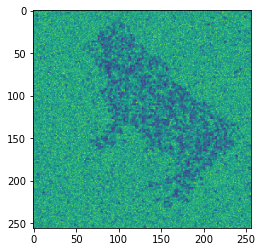

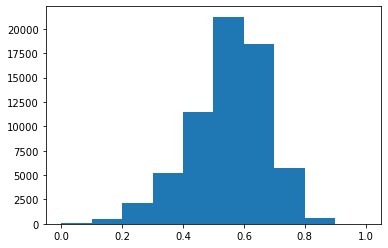

(array([-1.,  0.,  1.]), array([52486,  3480,  9570], dtype=int64))
cattle02.pgm
[0 1] uint8


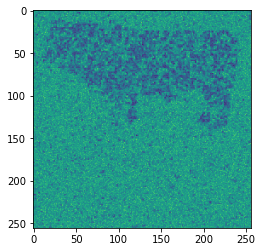

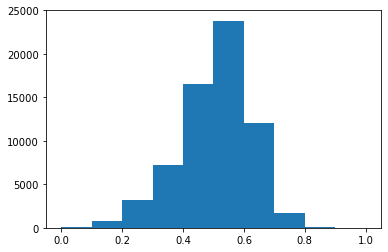

(array([-1.,  0.,  1.]), array([52575,  3616,  9345], dtype=int64))
cattle03.pgm
[0 1] uint8


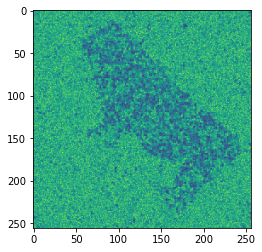

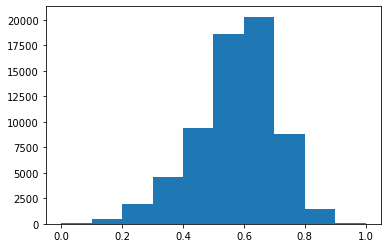

(array([-1.,  0.,  1.]), array([52423,  3599,  9514], dtype=int64))
cattle04.pgm
[0 1] uint8


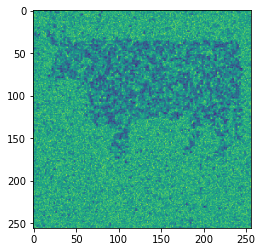

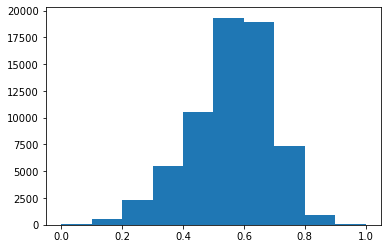

(array([-1.,  0.,  1.]), array([52370,  4332,  8834], dtype=int64))
cattle05.pgm
[0 1] uint8


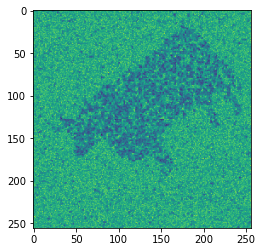

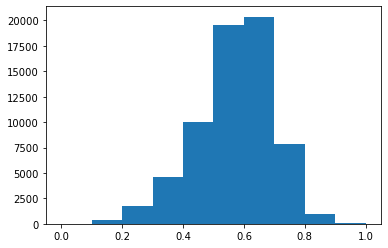

(array([-1.,  0.,  1.]), array([52441,  3382,  9713], dtype=int64))
cattle06.pgm
[0 1] uint8


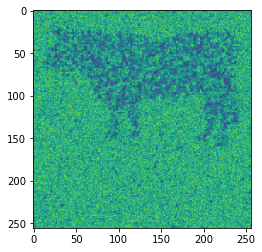

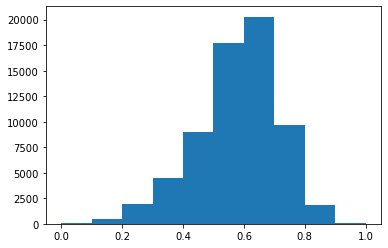

(array([-1.,  0.,  1.]), array([52440,  3660,  9436], dtype=int64))
cattle07.pgm
[0 1] uint8


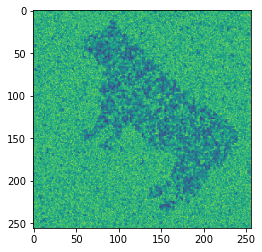

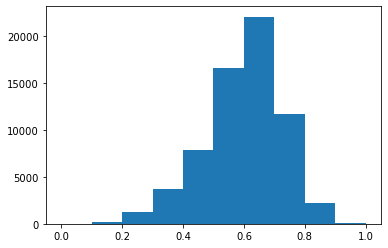

(array([-1.,  0.,  1.]), array([52441,  3435,  9660], dtype=int64))
cattle08.pgm
[0 1] uint8


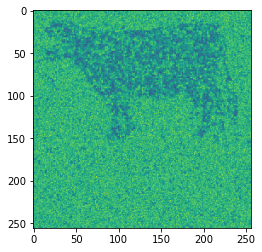

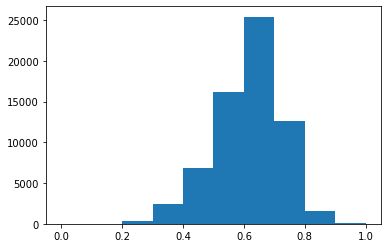

(array([-1.,  0.,  1.]), array([52382,  3677,  9477], dtype=int64))
cattle09.pgm
[0 1] uint8


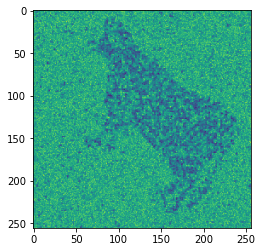

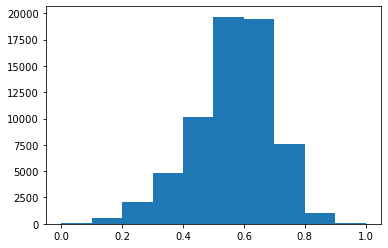

(array([-1.,  0.,  1.]), array([52442,  3439,  9655], dtype=int64))
cattle10.pgm
[0 1] uint8


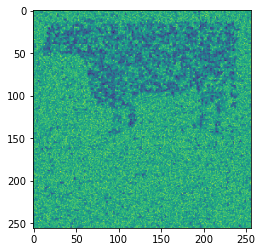

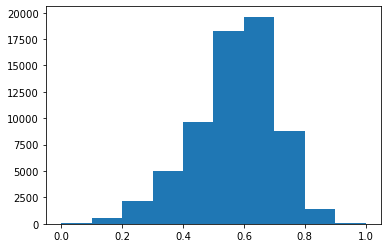

(array([-1.,  0.,  1.]), array([52334,  3839,  9363], dtype=int64))
cattle11.pgm
[0 1] uint8


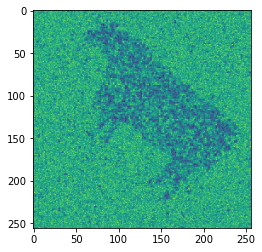

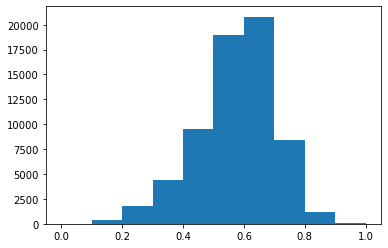

(array([-1.,  0.,  1.]), array([52324,  3430,  9782], dtype=int64))
cattle12.pgm
[0 1] uint8


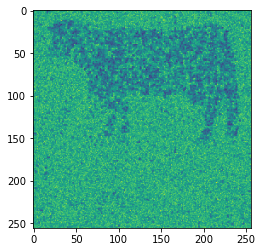

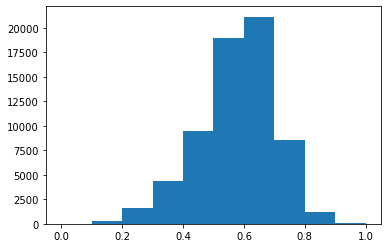

(array([-1.,  0.,  1.]), array([52311,  3686,  9539], dtype=int64))
cattle13.pgm
[0 1] uint8


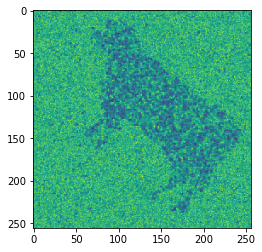

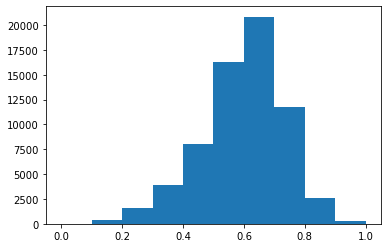

(array([-1.,  0.,  1.]), array([52624,  3404,  9508], dtype=int64))
cattle14.pgm
[0 1] uint8


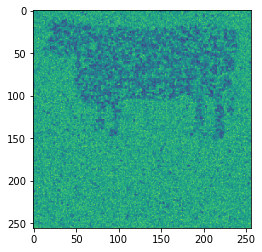

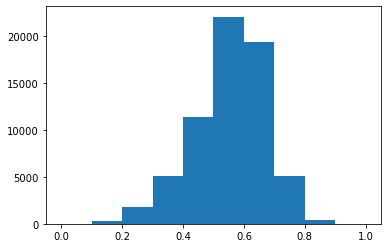

(array([-1.,  0.,  1.]), array([52415,  3997,  9124], dtype=int64))
cattle15.pgm
[0 1] uint8


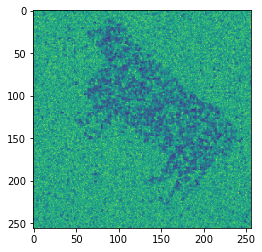

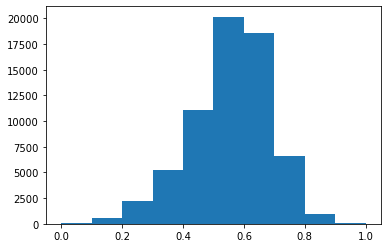

(array([-1.,  0.,  1.]), array([52744,  3442,  9350], dtype=int64))
cattle16.pgm
[0 1] uint8


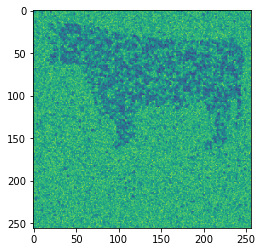

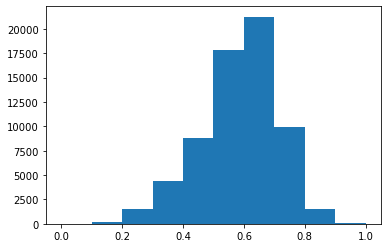

(array([-1.,  0.,  1.]), array([52467,  3813,  9256], dtype=int64))
cattle17.pgm
[0 1] uint8


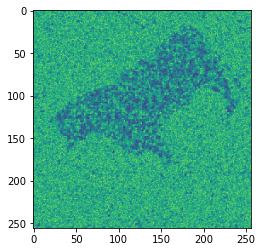

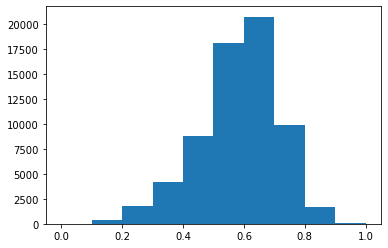

(array([-1.,  0.,  1.]), array([52550,  3174,  9812], dtype=int64))
cattle18.pgm
[0 1] uint8


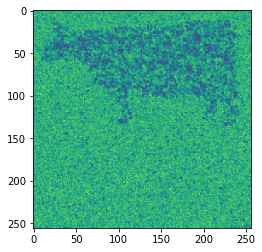

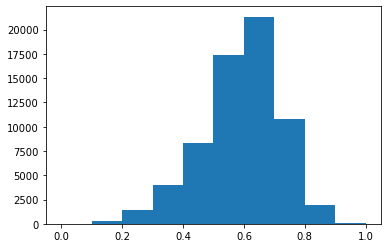

(array([-1.,  0.,  1.]), array([52194,  3540,  9802], dtype=int64))
cattle19.pgm
[0 1] uint8


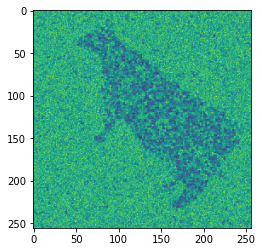

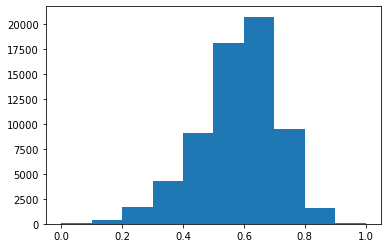

(array([-1.,  0.,  1.]), array([52397,  3311,  9828], dtype=int64))
cattle20.pgm
[0 1] uint8


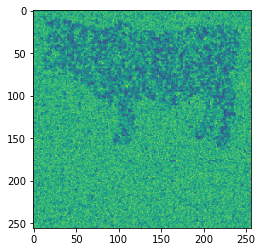

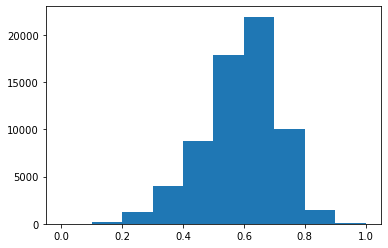

(array([-1.,  0.,  1.]), array([52527,  4185,  8824], dtype=int64))


In [405]:
type_image = 'cattle' # 'camel'
for size in [128, 256]:
     path_save = os.path.join(path_data, type_image+'_'+str(size))
     #* Create the images, fixed mu and sigma
     os.makedirs(path_save, exist_ok=True)
     multi_noise =  True if type_image == 'camel' else False #! True for multiplicative noise and False for additive noise
     print(type_image,'multi_noise: ', multi_noise)
     mu_general = 0.4
     mu_multi = 0.5
     mu = mu_general if not multi_noise else mu_multi
     sigma_general = 0.5
     sigma_multi = 0.2
     sigma  = sigma_general if not multi_noise else sigma_multi
     print('mu: ', mu, 'sigma: ', sigma)
     for image in os.listdir(path):
          if image.startswith(type_image):
               image_file = os.path.join(path, image)
               print(image)
               image_x, image_y = generate_noisy_image(image_file, size, mu, sigma, multi_noise)
               print(np.unique(image_y), image_y.dtype)
               if size == 256:
                    plt.imshow(image_x)
                    plt.show()
                    plt.hist(image_x.flatten())
                    plt.show()
               for p in [0.4, 0.6, 0.8]:
                    mask_miss = np.random.binomial(1, 1-p, size=(size, size))
                    label_miss = image_y.copy().astype('float64')
                    label_miss[mask_miss== 0] = -1    
                    np.save(os.path.join(path_save,f'{image[:-4]}_{str(int(p*100))}.npy'), [image_x, image_y.astype('float64'), label_miss ])
               print(np.unique(label_miss, return_counts=True))

## Previous version


In [386]:
def read_create_x_y_ymiss(image_file, size, mu, sigma, p, multi_noise):
    """
    Reads an image file, creates a noisy version of the image, and generates a mask for missing pixels.

    Parameters:
    image_file (str): Path to the input image file.
    size (int): Size of the output image.
    mu (float): Mean of the noise.
    sigma (float): Standard deviation of the noise.
    p (float): Probability of a pixel being missing.
    multi_noise (bool): Whether to use multiplicative noise.

    Returns:
    image_x (ndarray): Noisy version of the input image.
    image (ndarray): Original input image.
    label_miss (ndarray): Mask for missing pixels.
    """
    # Check if image file exists
    if not os.path.isfile(image_file):
        raise ValueError(f"File '{image_file}' does not exist.")

    # Load image
    image = plt.imread(image_file)
    # image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    # Resize image
    image = cv2.resize(image, (size, size)).astype('float32')
    _, image = cv2.threshold(image, 127, 1, cv2.THRESH_BINARY)
    # Convert image to chain
    chain = image_to_chain(image)

    # Generate noisy chain
    x = np.zeros(len(chain))
    if multi_noise:
        z = np.random.randn(len(chain))
        for t in range(len(chain)):
            x[t] = z[t] * np.random.normal(mu * chain[t], sigma, 1)
    else:
        for t in range(len(chain)):
            if t == 0:
                x[t] = np.random.normal(np.sin(mu * chain[t]), sigma, 1)

            else:
                x[t] = np.random.normal(np.sin(mu * chain[t] + x[t-1]), sigma, 1)
    # Convert chain to image
    image_x = chain_to_image(x).reshape(size, size)

    # Normalize image to range of 0 to 1
    # image_norm = (image_x.astype('float32') - np.min(image_x)) / (np.max(image_x) - np.min(image_x))
    image_norm = cv2.normalize(image_x.astype('float32'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    # image_norm = (image_norm.astype('float32') - np.min(image_norm)) / (np.max(image_norm) - np.min(image_norm))
    
    # Generate mask for missing pixels
    mask_missing = np.random.choice([0,1], size=image.shape, p=[p, 1-p])
    # mask_missing = np.random.rand(size, size) > p
    label_miss = image.copy()
    label_miss[mask_missing == 0] = -1

    return image_norm, image, label_miss

In [ ]:
seed = 19594
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(seed)     # python random generator
np.random.seed(seed) 
from utils.utils_semi import *

path = r'C:\Users\kmorales\Downloads\1070db.tar\pgms'
path_data = r'C:\Users\kmorales\Google Drive\PhD\Simulations_semi_super\Data'


# type_image = 'camel' #! Camel multiplicative noise and catte additive noise
# type_image = 'camel'
# size = 256 #* another option is 256
# # p = 0.6 #* probability of missing labels
# print('size: ', size)
# path_save = os.path.join(path_data, type_image+'_'+str(size))


# #* Create the images, fixed mu and sigma
# os.makedirs(path_save, exist_ok=True)
# multi_noise =  True if type_image == 'camel' else False #! True for multiplicative noise and False for additive noise
# print(type_image,'multi_noise: ', multi_noise)
# mu_general = 0.4
# mu_multi = 0.5
# mu = mu_general if not multi_noise else mu_multi
# sigma_general = 0.5
# sigma_multi = 0.2
# sigma  = sigma_general if not multi_noise else sigma_multi
# print('mu: ', mu, 'sigma: ', sigma)

In [372]:
def read_create_x_y_ymiss(image_file, size, mu, sigma, p, multi_noise):
    """
    Reads an image file, creates a noisy version of the image, and generates a mask for missing pixels.

    Parameters:
    image_file (str): Path to the input image file.
    size (int): Size of the output image.
    mu (float): Mean of the noise.
    sigma (float): Standard deviation of the noise.
    p (float): Probability of a pixel being missing.
    multi_noise (bool): Whether to use multiplicative noise.

    Returns:
    image_x (ndarray): Noisy version of the input image.
    image (ndarray): Original input image.
    label_miss (ndarray): Mask for missing pixels.
    """
    # Check if image file exists
    if not os.path.isfile(image_file):
        raise ValueError(f"File '{image_file}' does not exist.")

    # Load image
    image = plt.imread(image_file)
    # image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    # Resize image
    image = cv2.resize(image, (size, size)).astype('float32')
    _, image = cv2.threshold(image, 127, 1, cv2.THRESH_BINARY)
    # Convert image to chain
    chain = image_to_chain(image)

    # Generate noisy chain
    x = np.zeros(len(chain))
    if multi_noise:
        z = np.random.randn(len(chain))
        for t in range(len(chain)):
            x[t] = z[t] * np.random.normal(mu * chain[t], sigma, 1)
    else:
        for t in range(len(chain)):
            if t == 0:
                x[t] = np.random.normal(np.sin(mu * chain[t]), sigma, 1)

            else:
                x[t] = np.random.normal(np.sin(mu * chain[t] + x[t-1]), sigma, 1)
    # Convert chain to image
    image_x = chain_to_image(x).reshape(size, size)

    # Normalize image to range of 0 to 1
    # image_norm = (image_x.astype('float32') - np.min(image_x)) / (np.max(image_x) - np.min(image_x))
    image_norm = cv2.normalize(image_x.astype('float32'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    # image_norm = (image_norm.astype('float32') - np.min(image_norm)) / (np.max(image_norm) - np.min(image_norm))
    
    # Generate mask for missing pixels
    mask_missing = np.random.choice([0,1], size=image.shape, p=[p, 1-p])
    # mask_missing = np.random.rand(size, size) > p
    label_miss = image.copy()
    label_miss[mask_missing == 0] = -1

    return image_norm, image, label_miss

In [373]:
#* Do not run this part only if you want to create the images again
for type_image in ['camel', 'cattle']:
     for size in [128, 256]:
          path_save = os.path.join(path_data, type_image+'_'+str(size))
          #* Create the images, fixed mu and sigma
          os.makedirs(path_save, exist_ok=True)
          multi_noise =  True if type_image == 'camel' else False #! True for multiplicative noise and False for additive noise
          print(type_image,'multi_noise: ', multi_noise)
          mu_general = 0.4
          mu_multi = 0.5
          mu = mu_general if not multi_noise else mu_multi
          sigma_general = 0.5
          sigma_multi = 0.2
          sigma  = sigma_general if not multi_noise else sigma_multi
          print('mu: ', mu, 'sigma: ', sigma)
          for p in [0.60, 0.80]:
               for image in os.listdir(path):
                    if image.startswith(type_image):
                         image_file = os.path.join(path, image)
                         print(image)
                         image_x, image_y, label_miss = read_create_x_y_ymiss(image_file, size, mu, sigma, p, multi_noise)
                         print(np.max(image_x), np.min(image_x))
                         # plt.imshow(image_x)
                         # plt.show()
                         # plt.imshow(image_y)
                         # plt.show()
                         # plt.imshow(label_miss)
                         # plt.show()
                         np.save(os.path.join(path_save,f'{image[:-4]}_{str(int(p*100))}.npy'), [image_x, image_y, label_miss ])



camel multi_noise:  True
mu:  0.5 sigma:  0.2
camel04.pgm
1.0 1.2859406e-08
camel06.pgm
1.0 -1.2944334e-08
camel07.pgm
1.0 2.8571673e-08
camel08.pgm
1.0 -8.259391e-09
camel12.pgm
1.0 7.806257e-09
camel13.pgm
1.0 1.3299125e-08
camel14.pgm
1.0 5.7601426e-09
camel15.pgm
1.0 -1.9881952e-08
camel16.pgm
1.0 4.2146553e-10
camel17.pgm
1.0 -2.326055e-08
camel19.pgm
1.0000001 2.3004656e-08
camel20.pgm
0.99999994 -2.9558834e-08
camel04.pgm
1.0 1.06497815e-08
camel06.pgm
1.0 -2.217174e-09
camel07.pgm
1.0 -8.9399066e-10
camel08.pgm
1.0 1.2769156e-08
camel12.pgm
1.0 -1.0004229e-08
camel13.pgm
1.0 -3.2076386e-10
camel14.pgm
1.0 -9.673283e-09
camel15.pgm
1.0 3.2566199e-09
camel16.pgm
1.0 -1.1811778e-08
camel17.pgm
1.0 1.4413082e-08
camel19.pgm
1.0 -7.926243e-09
camel20.pgm
1.0 3.095579e-09
camel multi_noise:  True
mu:  0.5 sigma:  0.2
camel04.pgm
1.0 -8.932091e-09
camel06.pgm
1.0 -3.5770569e-09
camel07.pgm
1.0 3.1437004e-09
camel08.pgm
1.0 -1.2777619e-09
camel12.pgm
1.0 7.8951885e-09
camel13.pgm
1.0 1

## Otro code

In [354]:
image = plt.imread(os.path.join(path, 'camel07.pgm'))
image = cv2.resize(image, (size, size))
_, image = cv2.threshold(image, 127, 1, cv2.THRESH_BINARY)
print(np.unique(image))

[0 1]


In [365]:
image_xx, image, label_miss = read_create_x_y_ymiss(os.path.join(path, 'camel07.pgm') , size, mu, sigma, p, multi_noise)

In [366]:
print(np.unique(image))


[0. 1.]


In [367]:
# image_xx = image_xx.astype('float32')
print(image_xx.dtype)
print(np.max(image_xx), np.min(image_xx))
print(np.max(image), np.min(image))
print(np.max(label_miss), np.min(label_miss))
print(np.unique(label_miss))
print(np.unique(image))
print(image.dtype)
print(label_miss.dtype)

float32
1.0000001 2.9063521e-08
1.0 0.0
1.0 -1.0
[-1.  0.  1.]
[0. 1.]
float32
float32


In [368]:
print(np.min(image_xx), np.max(image_xx))
print(np.min(image), np.max(image))
print(np.min(label_miss), np.max(label_miss))

2.9063521e-08 1.0000001
0.0 1.0
-1.0 1.0


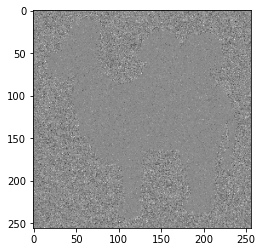

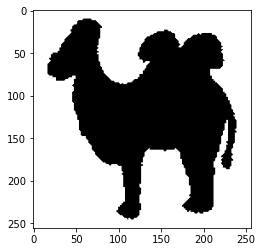

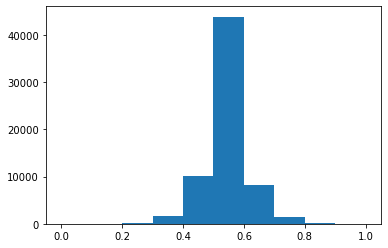

In [369]:
plt.imshow(image_xx, cmap='gray')
plt.show()
plt.imshow(image, cmap='gray')
plt.show()
image_flat = image_xx.flatten()
# Plot histogram
plt.hist(image_flat)
plt.show()

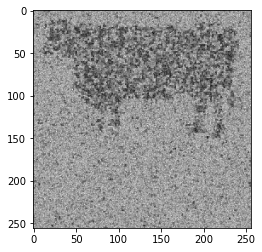

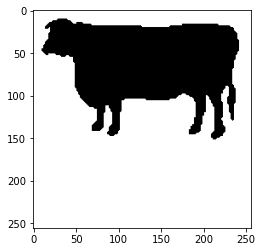

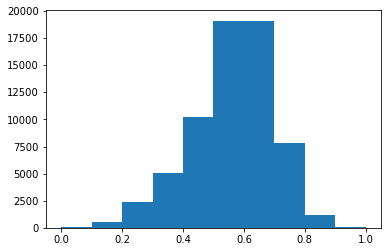

In [360]:

plt.imshow(image_xx, cmap='gray')
plt.show()
plt.imshow(image, cmap='gray')
plt.show()
image_flat = image_xx.flatten()
# Plot histogram
plt.hist(image_flat)
plt.show()

In [246]:
[file for file in os.listdir(path_save) if file.endswith('.npy') and 'camel07' in file]
file for 

SyntaxError: invalid syntax (<ipython-input-246-a53e090fbe3d>, line 2)

7.8951885e-09 1.0 0.0 1.0 -1.0 1.0


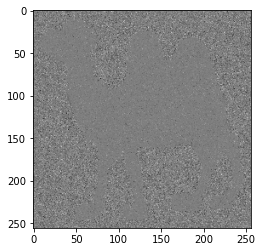

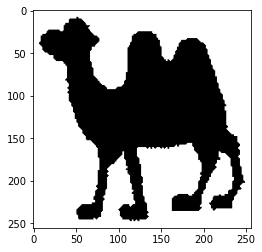

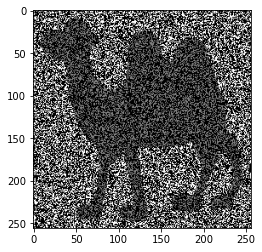

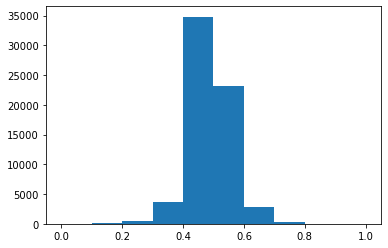

In [378]:
type_image = 'camel'
size = 256 #* another option is 256
path_save = os.path.join(path_data, type_image+'_'+str(size))

image = np.load(os.path.join(path_save, 'camel12_60.npy'))
x1, y_true, y_miss  = image
print(np.min(x1), np.max(x1), np.min(y_true), np.max(y_true), np.min(y_miss), np.max(y_miss))
plt.imshow(x1, cmap='gray')
plt.show()
plt.imshow(y_true, cmap='gray')    
plt.show()
plt.imshow(y_miss, cmap='gray')
plt.show()
image_flat = x1.flatten()
# Plot histogram
plt.hist(image_flat)
plt.show()

0.0 1.0 0.0 1.0 -1.0 1.0


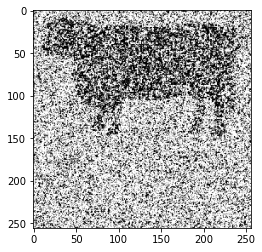

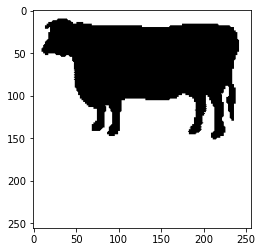

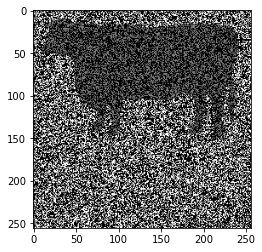

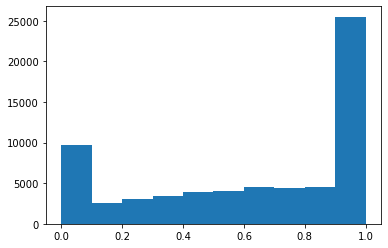

In [275]:
image = np.load(os.path.join(path_save, 'cattle14_60.npy'))
x1, y_true, y_miss  = image
print(np.min(x1), np.max(x1), np.min(y_true), np.max(y_true), np.min(y_miss), np.max(y_miss))
plt.imshow(x1, cmap='gray')
plt.show()
plt.imshow(y_true, cmap='gray')    
plt.show()
plt.imshow(y_miss, cmap='gray')
plt.show()
image_flat = x1.flatten()
# Plot histogram
plt.hist(image_flat)
plt.show()

0.0 1.0 0.0 1.0 -1.0 1.0


In [95]:
# #* Do not run this part only if you want to create the images again
# for p in [0.60, 0.80]:
#     for image in os.listdir(path):
#         if image.startswith(type_image):
#             image_file = os.path.join(path, image)
#             print(image)
#             image_x, image_y, label_miss = read_create_x_y_ymiss(image_file, size, mu, sigma, p, multi_noise)
#             print(np.max(image_x), np.min(image_x))
#             # plt.imshow(image_x)
#             # plt.show()
#             # plt.imshow(image_y)
#             # plt.show()
#             # plt.imshow(label_miss)
#             # plt.show()
#             np.save(os.path.join(path_save,f'{image[:-4]}_{str(int(p*100))}.npy'), [image_x, image_y, label_miss ])



camel04.pgm


1.0 0.0
camel06.pgm
1.0 0.0
camel07.pgm
1.0 0.0
camel08.pgm
1.0 0.0
camel12.pgm
1.0 0.0
camel13.pgm
1.0 0.0
camel14.pgm
1.0 0.0
camel15.pgm
1.0 0.0
camel16.pgm
1.0 0.0
camel17.pgm
1.0 0.0
camel19.pgm
1.0 0.0
camel20.pgm
1.0 0.0
camel04.pgm
1.0 0.0
camel06.pgm
1.0 0.0
camel07.pgm
1.0 0.0
camel08.pgm
1.0 0.0
camel12.pgm
1.0 0.0
camel13.pgm
1.0 0.0
camel14.pgm
1.0 0.0
camel15.pgm
1.0 0.0
camel16.pgm
1.0 0.0
camel17.pgm
1.0 0.0
camel19.pgm
1.0 0.0
camel20.pgm
1.0 0.0


len(list_images):  12


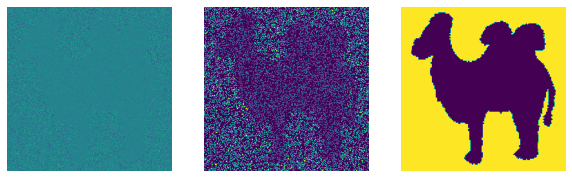

In [4]:
seed = 123
import os
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import random
import torch
import configparser

random.seed(seed)     # python random generator
np.random.seed(seed)  # numpy random generator

torch.manual_seed(seed) # pytorch random generator
torch.cuda.manual_seed_all(seed) # for multi-gpu

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#--------------------------------------------
from models.models_v3 import *
from utils.utils_semi import *
from utils.training import run_model_seq, num_param    
#--------------------------------------------
path = os.getcwd()
folder_data = r'Data'
#-------------------------------
if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"  
print('Your actual device',device)
#----------------------------------------------
general_path  = os.path.join(os.getcwd(), 'Results_save_models') 

# Load configuration files
data_config = configparser.ConfigParser()
data_config.read('data_config.ini')

model_config = configparser.ConfigParser()
model_config.read('model_config.ini')


In [103]:
general_path  = os.path.join(os.getcwd(), 'Results_save_models') 
options = [f for f in os.listdir(general_path) if not f.endswith('.ini') and not f.endswith('.csv') and not f.endswith('.ipynb') and not f.endswith('.py') and not f.endswith('.txt') and not f.endswith('.md')]
print(options)

# Display options
for i, option in enumerate(options):
    print(f"{i}: {option}")

# Prompt user for choice
choice = input("Choose an option (enter index): ")

# Check if choice is valid
if choice.isdigit() and int(choice) in range(len(options)):
    index = int(choice)
    print(f"You chose {options[index]}.")
else:
    print("Invalid choice.")
file_data = [f for f in os.listdir(general_path) if f.endswith('.ini') and options[index] in f]
file_data

['tmm_camel07_60']
0: tmm_camel07_60
You chose tmm_camel07_60.


['data_config_tmm_camel07_60.ini', 'model_config_tmm_camel07_60.ini']

In [5]:
print(np.unique(y_true))
print(np.unique(image_y))
print(np.unique(image_x))


[0. 1.]
[-1.  0.  1.]
[-2.99503477 -2.81904692 -2.77557669 ...  3.05491835  3.20112241
  3.7150523 ]


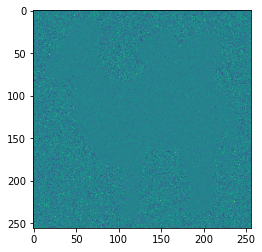

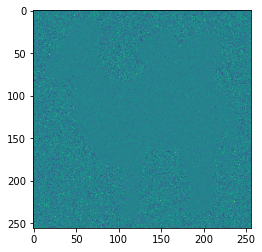

In [7]:
normalized_img = (image_x.astype('float') - np.min(image_x)) / (np.max(image_x) - np.min(image_x))
# Display the original and normalized images
plt.imshow(image_x)
plt.show()
plt.imshow(normalized_img)
plt.show()

In [68]:
# Simulations gpu
seed = 123
import os
import numpy as np
import matplotlib.pyplot as plt
import configparser

#--------------------------------------------
from models.models_v3 import *
from utils.utils_semi import *
from utils.training import run_model_seq, num_param
#--------------------------------------------
path = os.getcwd()
folder_data = r'Data'
#-------------------------------
if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"  
print('Your actual device',device)
#----------------------------------------------
# Load configuration files
data_config = configparser.ConfigParser()
data_config.read('data_config.ini')

model_config = configparser.ConfigParser()
model_config.read('model_config.ini')

# Get input values from configuration files or prompt user for input
type_image = data_config.get('data_settings', 'type_image', fallback=None)
if type_image=='-1':
    type_image = input("Enter the type of image (camel or cattle): ")
    data_config.set('data_settings', 'type_image', type_image)
size = data_config.getint('data_settings', 'size', fallback=None)
if size not in [128, 256]:
    size = int(input("Enter the size of the image (128 or 256): "))
    data_config.set('data_settings', 'size', str(size))
p = data_config.getint('data_settings', 'p', fallback=None)
if p<0 or p>100:
    p = int(input("Enter the percentage of missing labels (0 to 100): "))
    data_config.set('data_settings', 'p', str(p))
print(f"Data info: {type_image}, {size}, {p}")
#----------------------------------------------
# Path to save the model
path_data = os.path.join(path, folder_data, type_image+'_'+str(size))
print('Exist this folder', os.path.exists(path_data))
general_path  = os.path.join(os.getcwd(), 'Results_save_models') 
os.makedirs(general_path, exist_ok=True)
print('Saving our model in',general_path)
#----------------------------------------------
list_images = []
names_images = []
for data in sorted(os.listdir(path_data)):
    if data.endswith('.npy') and str(p) in data:
        x= np.load(os.path.join(path_data, data))
        image_x, y_true, image_y = x
        print(np.max(image_x), np.min(image_x))
        list_images.append(np.load(os.path.join(path_data, data)))
        names_images.append(data[:-4])


Your actual device cpu
Data info: camel, 128, 60
Exist this folder True
Saving our model in c:\Users\kmorales\Google Drive\PhD\Simulations_semi_super\Results_save_models
3.9774793744484302 -3.0148255383180573
3.6201785242002775 -3.5724932048940157
2.4108754296252606 -3.4784155926828397
2.686470437698127 -2.9097459360804314
2.641521812577071 -2.5864305451621514
2.5453954982371156 -3.0946966304278902
2.9848824855716516 -2.7992273445210163
2.48596020736623 -2.570087013542149
2.8445031691127234 -2.404986975041959
3.9812097060295515 -3.3394546756280055
3.005767543770049 -3.032257572037903
3.10799060130871 -2.299987140400865


In [27]:
print(np.max(image_x), np.min(image_x))

3.587095565916296 -3.6639853587765066


In [56]:
# Simulations gpu
seed = 123
import os
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import random
import torch
random.seed(seed)     # python random generator
np.random.seed(seed)  # numpy random generator

torch.manual_seed(seed) # pytorch random generator
torch.cuda.manual_seed_all(seed) # for multi-gpu

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#--------------------------------------------
from models.models_v3 import *
from utils.utils_semi import *
from utils.training import *
#--------------------------------------------
# Change the name to create or load the data and models
path = os.getcwd()
folder_data = r'Data'
#-------------------------------
if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"  
print('device',device)

# #! Data settings
# Prompt the user to enter an integer
type_image = str(input("Enter an option (camel or cattle): "))
print("You entered:", type_image)
size =  int(input("Enter the size of the image (128 or 256): "))
print("You entered:", size)
p =  int(input("Enter the percentage of missing labels (0 to 100): "))
print("You entered:", p)
path_save = os.path.join(path, folder_data, type_image+'_'+str(size))
print('Exist this folder', os.path.exists(path_save))

list_images = []
names_images = []
for data in os.listdir(path_save):
    if data.endswith('.npy') and str(p) in data:
        list_images.append(np.load(os.path.join(path_save, data)))
        names_images.append(data[:-4])
print('len(list_images): ', len(list_images))
index =  int(input(f"Enter an index from 0 to {len(list_images)-1}: "))
name_image = names_images[index]
print('index', index, name_image)

image_x, y_true, image_y = list_images[index]

x = torch.tensor(image_x.reshape(size*size, 1), dtype=torch.float32)
y = torch.tensor(image_y.reshape(size*size, 1), dtype=torch.float32)
x = x.to(device)
y = y.to(device)

#----------------------------------------------
# General model settings
x_dim = 1
y_dim = 1
weight_decay_ = 1e-4
clip = 10

learning_rate = float(input("Enter the value for learning_rate: "))
n_epochs = int(input("Enter the value for n_epochs: "))
# print_every = int(input("Enter the value for print_every: "))
# save_every = int(input("Enter the value for save_every: "))

general_path  = os.path.join(os.getcwd(), 'Results_save_models') 
os.makedirs(general_path, exist_ok=True)
print('Saving our model in',general_path)

# Specific settings 
z_dim = int(input("Enter the value for z_dim: "))
h_dim = int(input("Enter the value for h_dim: "))
num_neurons = int(input("Enter the value for num_neurons: "))
add_loss =True # input("Enter 'True' if add_loss should be True, or 'False' otherwise: ").lower() == 'true'
sel_model = input('Model to run (tmm, vls, svrnn) ').lower()
setting = '' if add_loss else 'no_add'
epoch_init = int(input("Enter the value for epoch_init (from 1 to --): "))

if sel_model == 'tmm':
    model = TMM(x_dim, z_dim, y_dim, h_dim, num_neurons, device, add_loss)
if sel_model == 'vls':
    model = VSL( x_dim, z_dim, y_dim, h_dim, num_neurons, device)
if sel_model == 'svrnn':
    model = SVRNN(x_dim, z_dim, h_dim, y_dim, num_neurons, device, add_loss)

# print( f'epoch_init = {epoch_init}, z_dim = {z_dim}, num_neurons = {num_neurons}, h_dim = {h_dim}, add_loss = {add_loss}, learning_rate = {learning_rate}, n_epochs = {n_epochs}, print_every = {print_every}, save_every = {save_every}, model = {model.__class__.__name__}')

#--------------------------------------------
# Save models
#--------------------------------------------
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay_)
print(f'{model.__class__.__name__ } has {num_param(model)} parameters to train' )
print(f'z_dim = {z_dim}, num_neurons = {num_neurons}, h_dim = {h_dim}')
data = model.__class__.__name__.casefold()+'_'+name_image+setting
path_save = os.path.join(general_path, data)
if not os.path.exists(path_save):
    os.makedirs(path_save)
print(f'Actual path to save our models for {data} is \n {path_save} ')

#* Training
# loss = run_model_seq(x, y,model,optimizer,clip, path_save, n_epochs,save_every, print_every)


device cpu
You entered: camel
You entered: 128
You entered: 60
Exist this folder True
len(list_images):  12
index 2 camel07_60
Saving our model in c:\Users\kmorales\Google Drive\PhD\Simulations_semi_super\Results_save_models
TMM has 1446 parameters to train
z_dim = 1, num_neurons = 25, h_dim = 14
Actual path to save our models for tmm_camel07_60 is 
 c:\Users\kmorales\Google Drive\PhD\Simulations_semi_super\Results_save_models\tmm_camel07_60 


In [104]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay_)
print(f'{model.__class__.__name__ } has {num_param(model)} parameters to train' )
print(f'z_dim = {z_dim}, num_neurons = {num_neurons}, h_dim = {h_dim}')
data = model.__class__.__name__.casefold()+'_'+name_image+setting
path_save = os.path.join(general_path, data)
if not os.path.exists(path_save):
    os.makedirs(path_save)
print(f'Actual path to save our models for {data} is \n {path_save} ')


TMM has 1446 parameters to train
z_dim = 1, num_neurons = 25, h_dim = 14
Actual path to save our models for tmm_camel07_60 is 
 c:\Users\kmorales\Google Drive\PhD\Simulations_semi_super\Results_save_models\tmm_camel07_60 


In [58]:
from utils.training import *


In [105]:
model = model_reconstruction(model,epoch_init, path_save, device)

Actual  path for to initialize our models:  c:\Users\kmorales\Google Drive\PhD\Simulations_semi_super\Results_save_models\tmm_camel07_60
Initialization of the TMM model  at epoch 100
loss:  {tensor(-48794.4141, requires_grad=True)} and epoch:  {100}


In [114]:
image_x, y_true, image_y = list_images[index]

x = torch.tensor(image_x.reshape(size*size, 1), dtype=torch.float32)
y = torch.tensor(image_y.reshape(size*size, 1), dtype=torch.float32)
x = x.to(device)
y = y.to(device)

In [115]:
y_ = model.reconstruction(x,y)

In [118]:
print(np.min(x.cpu().numpy()), np.max(x.cpu().numpy()))

-3.0148256 3.9774795


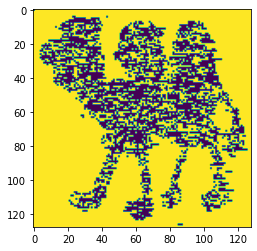

In [116]:
plt.imshow(y_.detach().cpu().numpy().reshape(size,size))

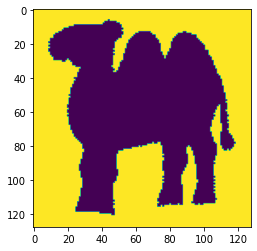

In [113]:
plt.imshow(y_.detach().cpu().numpy().reshape(size,size))

In [117]:
# #* Reconstruction
y_ = model.reconstruction(x,y)
if device == 'cuda:0':
    y_ = y_.cpu()
y_true_ = image_to_chain(y_true)
y1 = image_to_chain(image_y)
y_pred_m = y_[np.where(y1 == -1)].numpy()
y_true_m = y_true_[np.where(y1 == -1)]
error_rate = 1-accuracy_score(y_true_m, y_pred_m)
print(f'{name_image}: {model.__class__.__name__ } with  {num_param(model)} parameters \n after {epoch_init} has an error rate of {error_rate}\n folder {data}' )



camel07_60: TMM with  1446 parameters 
 after 100 has an error rate of 0.44022128880237676
 folder tmm_camel07_60


In [63]:
y_pred_m = y_[np.where(y1 == -1)].numpy()
y_true_m = y_true_[np.where(y1 == -1)]
error_rate = 1-accuracy_score(y_true_m, y_pred_m)
print(f'{name_image}: {model.__class__.__name__ } with  {num_param(model)} parameters \n after {epoch_init} has an error rate of {error_rate}\n folder {data}' )
y_tmm = y_.reshape(size, size).cpu().numpy()

camel07_60: TMM with  1446 parameters 
 after 100 has an error rate of 0.42843913982920057
 folder tmm_camel07_60


In [25]:
sorted(os.listdir(path_save))

['desktop.ini', 'tmm_state_100.pth', 'tmm_state_train_100.npy']

In [26]:
image_x

array([[-1.09820332,  0.51355493,  0.02203139, ..., -0.07101038,
         0.28081298,  0.18389915],
       [ 1.19759356,  1.25885594, -0.35228233, ..., -0.0512428 ,
         0.06358139,  0.16010344],
       [ 0.01706742,  0.44143397, -1.04102006, ..., -0.74724537,
         0.02052418,  0.93072747],
       ...,
       [ 0.49754826,  0.4498163 ,  0.134515  , ...,  0.60686583,
         0.08081697, -1.2398498 ],
       [ 0.04856148, -0.32599455, -0.61436975, ..., -0.44145543,
        -0.0909253 , -0.16822502],
       [-0.27487311, -0.42276562,  0.07693244, ...,  0.94992505,
        -0.96833317, -0.61160317]])